In [1]:
# load
from google.colab import drive
drive.mount('MyDrive', force_remount=True)
path = "/content/MyDrive/Shareddrives/Project CompBiomed/data"

Mounted at MyDrive


In [4]:
#!pip install wfdb
import wfdb
import glob
import os
import tqdm
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.interpolate import interp1d
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

## Dataset Load

In [5]:
df = pd.read_excel(path + '/df_with_max_value.xlsx',sheet_name='Sheet1')
df = pd.DataFrame(df)

In [6]:
df = df.apply(lambda col: col.map(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x))
print(f'the number of patient is {len(df)}')
df.head()

the number of patient is 190


,Unnamed: 0,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,...,Structures,Simplified_SOO,RVOTSEPTUM,COMMISURE,classified_SOO,RVOT,LVOT,avg_max_val,index_max_val,length_seg
0,P186,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,...,"{'2-LV': {'P36': {'I': array([-0.075, -0.075, ...",LVOTSUBVALVULAR,0,0,LVOT,0,1,1.305,64,64.0
1,P245,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,...,"{'2-RV': {'P157': {'I': array([ 0. , 0. ,...",RVOTFREEWALL,0,0,RVOT,1,0,0.894,55,55.0
2,P292,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,...,"{'2-AO': {'P55': {'I': array([-0.063, -0.051, ...",RCC,0,0,NaN,0,0,0.975,65,65.0
3,P205,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,...,"{'2-1-Rp-LV': {'P320': {'I': array([-0.297, -0...",RVOTFREEWALL,0,0,RVOT,1,0,0.363,41,41.0
4,P066,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,...,"{'1-PA': {'P13': {'I': array([-0.006, -0.003, ...",RVOTSEPTUM,1,0,RVOT,1,0,0.681,83,83.0


In [7]:
labelsDf = pd.read_excel(path + '/labels_FontiersUnsupervised.xlsx',sheet_name='Hoja2')
labels = dict(zip(labelsDf['SOO'], labelsDf['Simplified']))
df["Simplified_SOO"] = df["SOO"].map(labels)
df.head()

,Unnamed: 0,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,...,Structures,Simplified_SOO,RVOTSEPTUM,COMMISURE,classified_SOO,RVOT,LVOT,avg_max_val,index_max_val,length_seg
0,P186,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,...,"{'2-LV': {'P36': {'I': array([-0.075, -0.075, ...",LVOTSUBVALVULAR,0,0,LVOT,0,1,1.305,64,64.0
1,P245,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,...,"{'2-RV': {'P157': {'I': array([ 0. , 0. ,...",RVOTFREEWALL,0,0,RVOT,1,0,0.894,55,55.0
2,P292,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,...,"{'2-AO': {'P55': {'I': array([-0.063, -0.051, ...",RCC,0,0,NaN,0,0,0.975,65,65.0
3,P205,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,...,"{'2-1-Rp-LV': {'P320': {'I': array([-0.297, -0...",RVOTFREEWALL,0,0,RVOT,1,0,0.363,41,41.0
4,P066,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,...,"{'1-PA': {'P13': {'I': array([-0.006, -0.003, ...",RVOTSEPTUM,1,0,RVOT,1,0,0.681,83,83.0


# Visualization

In [8]:
df_vis = df.copy()
# Map sex binary to labels
sex_labels = {0: 'Female', 1: 'Male'}
df_vis['Sex_label'] = df_vis['Sex'].map(sex_labels)
# Define age bins
age_bins = [10,20, 30, 40, 50, 60, 70, 80,90]
age_labels = ['10-20','20-30', '31-40', '41-50', '51-60', '61-70', '71-80','81-90']
weight_bins = [40,50, 60, 70, 80, 90, 100, 110,120]
weight_labels = ['40-50','51-60', '61-70', '71-80', '81-90', '101-110', '111-120','121-130']
df_vis['Age_group'] = pd.cut(df_vis['Age'], bins=age_bins, labels=age_labels, right=False)
df_vis['Weight_group'] = pd.cut(df_vis['Weight'], bins=weight_bins, labels=weight_labels, right=False)

df_vis.head()

,Unnamed: 0,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,...,COMMISURE,classified_SOO,RVOT,LVOT,avg_max_val,index_max_val,length_seg,Sex_label,Age_group,Weight_group
0,P186,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,...,0,LVOT,0,1,1.305,64,64.0,NaN,61-70,NaN
1,P245,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,...,0,RVOT,1,0,0.894,55,55.0,NaN,51-60,61-70
2,P292,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,...,0,NaN,0,0,0.975,65,65.0,NaN,61-70,71-80
3,P205,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,...,0,RVOT,1,0,0.363,41,41.0,NaN,61-70,61-70
4,P066,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,...,0,RVOT,1,0,0.681,83,83.0,NaN,41-50,71-80


In [9]:
##########################################################
target = 'RVOT'
target2 = 'LVOT'
##########################################################

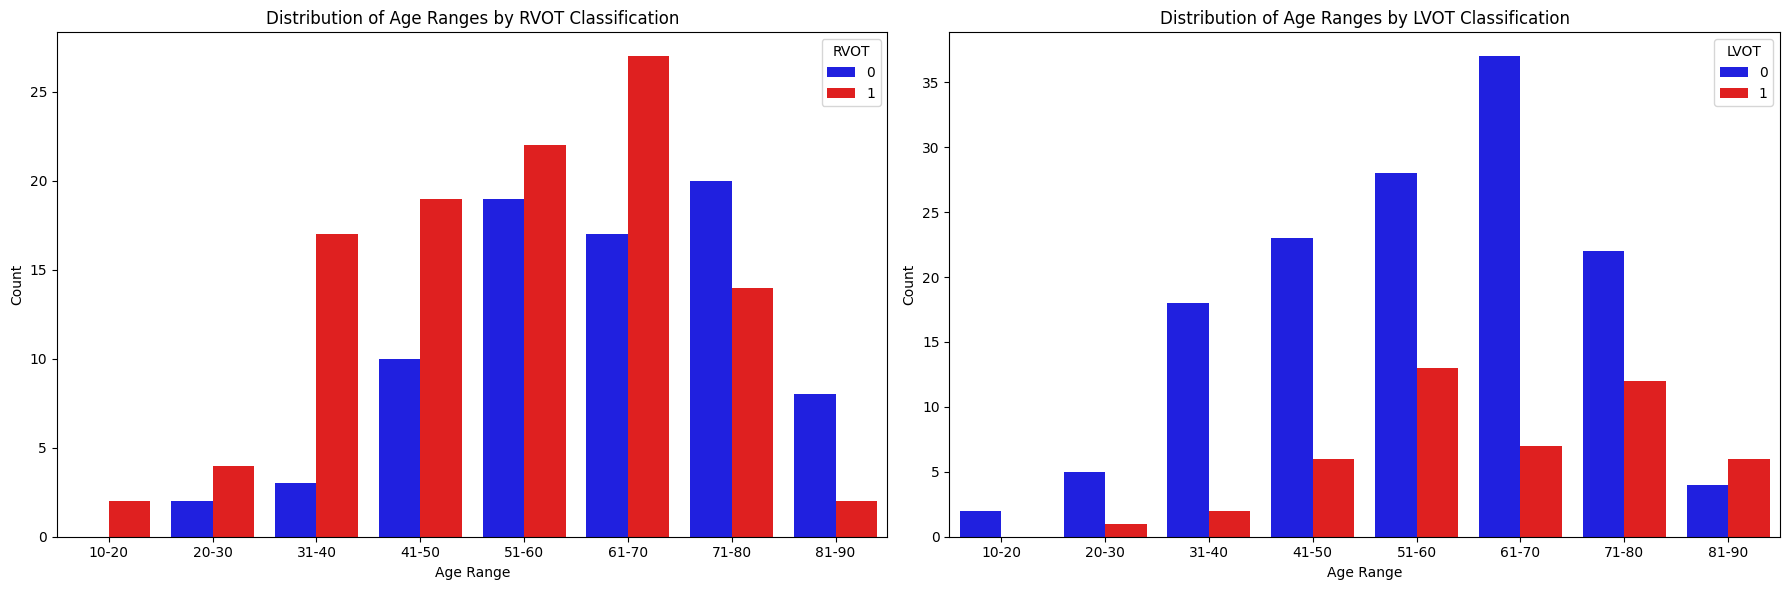

In [11]:
# Age range distribution for LVOT and RVOT
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(x='Age_group', ax=axes[0], hue=target, data=df_vis, palette={0: 'blue', 1: 'red'}, dodge=True)
axes[0].set_title('Distribution of Age Ranges by '+target +' Classification')
axes[0].set_xlabel('Age Range')
axes[0].set_ylabel('Count')

sns.countplot(x='Age_group', ax=axes[1], hue=target2, data=df_vis, palette={0: 'blue', 1: 'red'}, dodge=True)
axes[1].set_title('Distribution of Age Ranges by '+target2 +' Classification')
axes[1].set_xlabel('Age Range')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()

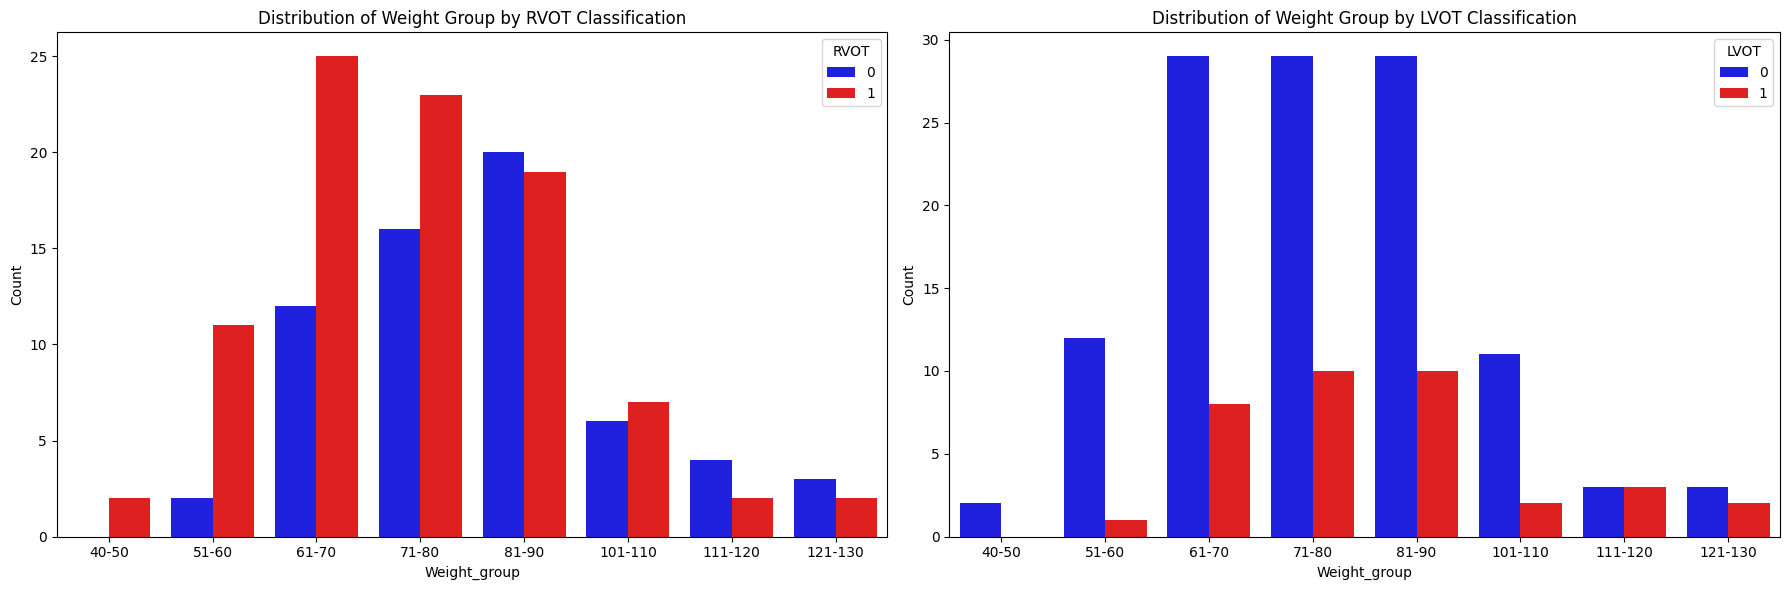

In [12]:
# Weight group distribution for LVOT and RVOT
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(x='Weight_group', ax=axes[0], hue=target, data=df_vis, palette={0: 'blue', 1: 'red'}, dodge=True)
axes[0].set_title('Distribution of Weight Group by '+target +' Classification')
axes[0].set_xlabel('Weight_group')
axes[0].set_ylabel('Count')

sns.countplot(x='Weight_group', ax=axes[1], hue=target2, data=df_vis, palette={0: 'blue', 1: 'red'}, dodge=True)
axes[1].set_title('Distribution of Weight Group by '+target2 +' Classification')
axes[1].set_xlabel('Weight_group')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()

In [13]:
# Funnction to do scatter plots
def visualization(target,x,y):

  plt.figure(figsize=(10, 8))

  palette = {0: 'blue', 1: 'red'}

  # Create the scatter plot
  sns.scatterplot(x=x, y=y, data=df_vis,
                  hue=target,
                  palette=palette,
                  s=100, alpha=0.6)

  # Add titles and labels
  plt.title( x + ' vs '+y+ ' colored by '+ target)
  plt.xlabel(x)
  plt.ylabel(y)
  plt.legend(title=target)
  plt.show()
  pass

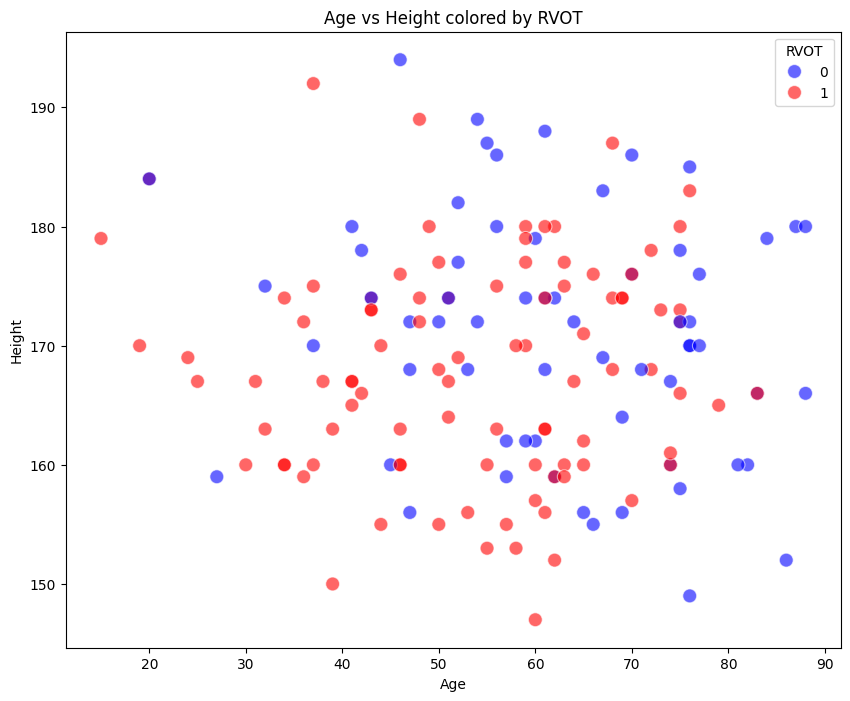

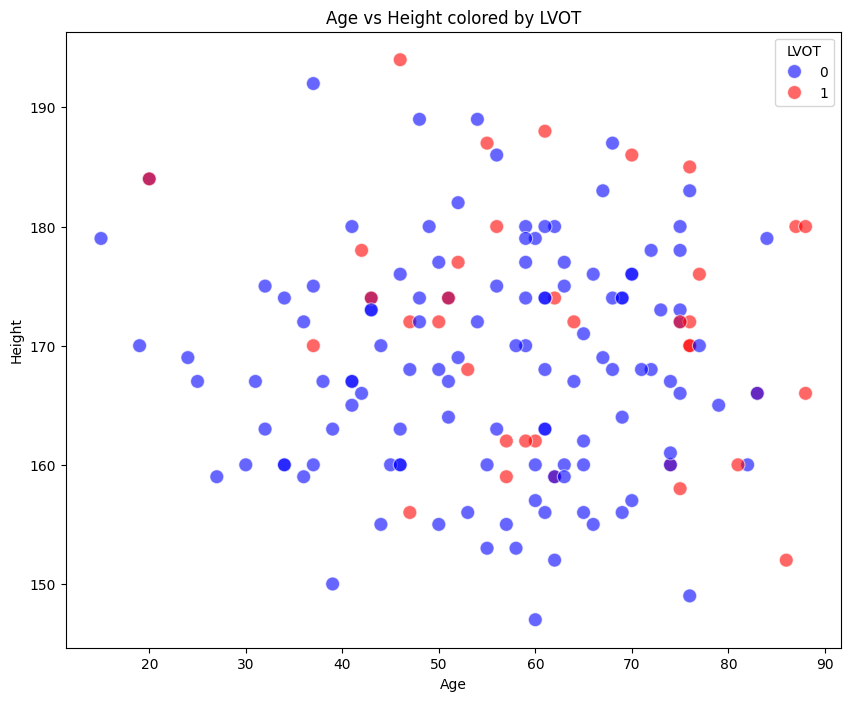

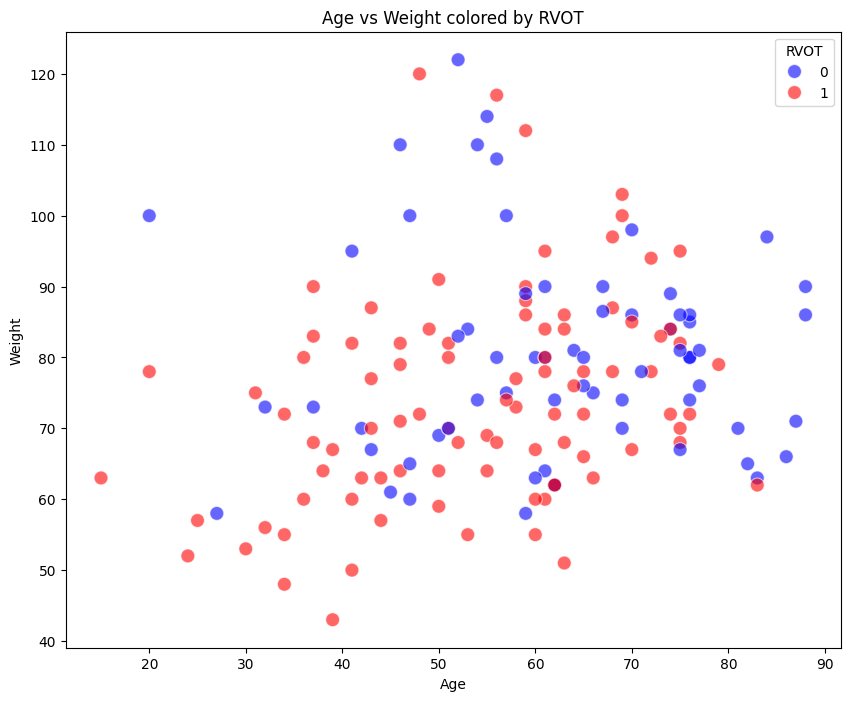

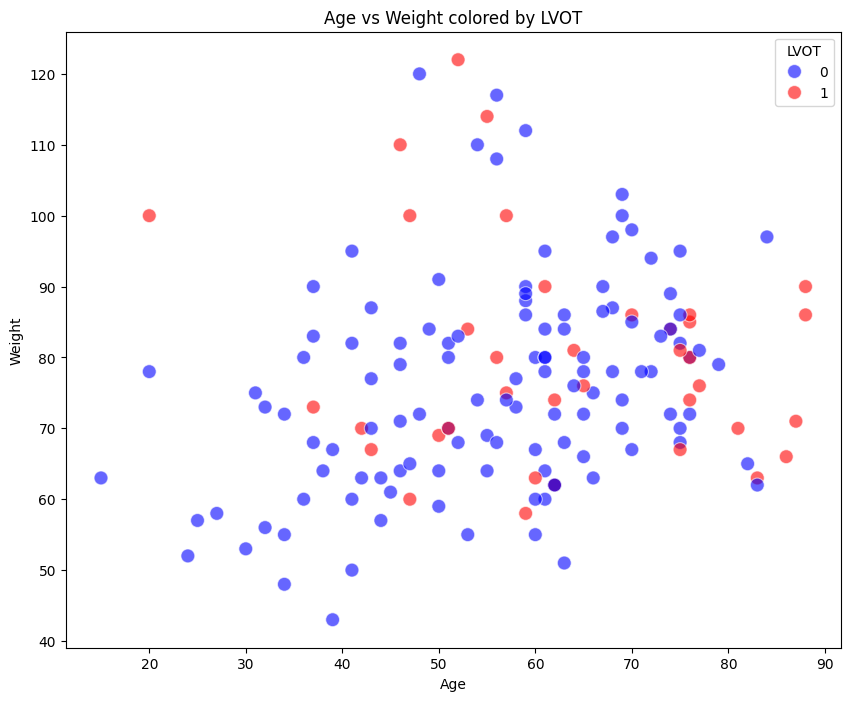

In [14]:
visualization(target,x='Age',y='Height');
visualization(target2,x='Age',y='Height');
visualization(target,x='Age',y='Weight');
visualization(target2,x='Age',y='Weight');

# PCA 2D

In [15]:
# Standardize the data
scaler = StandardScaler()
df_standardized = df.copy()

df_standardized['Sex'] = df['Sex'].map({'Female': 0, 'Male': 1})
df_standardized['HTA'] = df['HTA'].map({'No': 0, 'Yes': 1})
df_standardized = df_standardized[['Age', 'Sex', 'Weight','Height']]
df_standardized = df_standardized.dropna()
df_standardized = scaler.fit_transform(df_standardized)
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for 3D visualization
principal_components = pca.fit_transform(df_standardized)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])
pca_df = pd.concat([pca_df, df[[target]].reset_index(drop=True)], axis=1)

print("\nPCA Results Sample:\n", pca_df.head())


PCA Results Sample:
    principal_component_1  principal_component_2  RVOT
0              -0.989150               0.331460     0
1              -1.481068              -1.142730     1
2              -0.629281              -0.273403     0
3              -1.149551               0.355650     1
4               2.194909              -1.367603     1


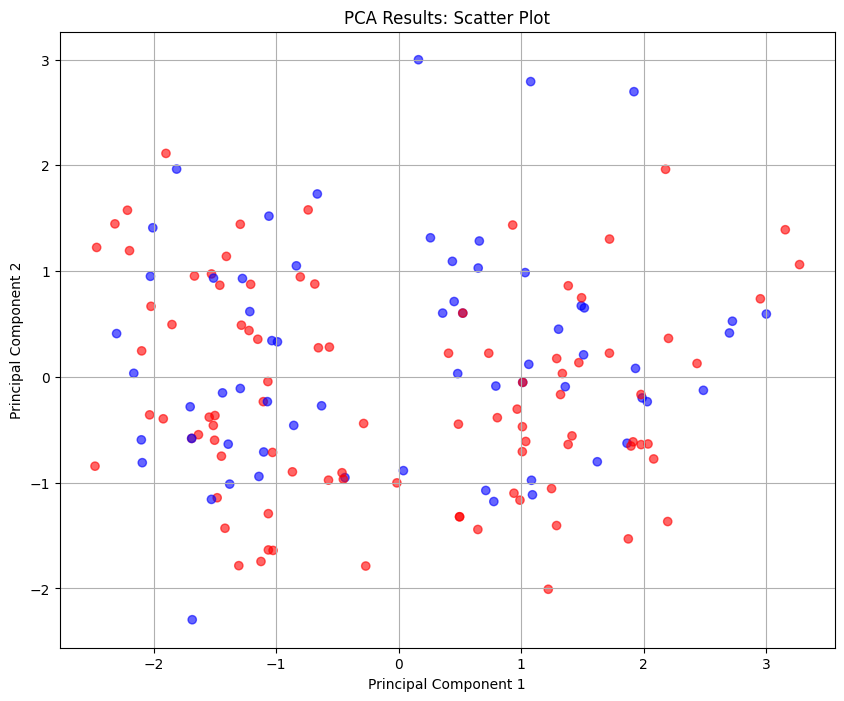

In [16]:
# Example scatter plot of PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['principal_component_1'], pca_df['principal_component_2'],
                      c=pca_df[target],
                      cmap='bwr', alpha=0.6)
plt.title('PCA Results: Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# ML Algorithm

## Data Preparation

In [17]:
dfMl = df[['Sex', 'HTA', 'Age', 'Height', 'Weight', 'DM', 'DLP', 'Smoker', 'Sleep_apnea', 'CLINICAL_SCORE','LVOT','RVOT','RVOTSEPTUM','COMMISURE','avg_max_val','index_max_val','length_seg']]

In [18]:
dfMl = dfMl.dropna()
print(len(dfMl))
dfMl.head()

152


,Sex,HTA,Age,Height,Weight,DM,DLP,Smoker,Sleep_apnea,CLINICAL_SCORE,LVOT,RVOT,RVOTSEPTUM,COMMISURE,avg_max_val,index_max_val,length_seg
1,Female,No,52.0,169.0,68.0,No,No,No,No,1.0,0,1,0,0,0.894,55,55.0
2,Female,No,69.0,156.0,70.0,No,Yes,No,No,1.0,0,0,0,0,0.975,65,65.0
3,Female,No,66.0,176.0,63.0,No,No,No,No,1.0,0,1,0,0,0.363,41,41.0
4,Female,Yes,46.0,160.0,79.0,No,No,No,No,1.0,0,1,1,0,0.681,83,83.0
6,Male,No,84.0,179.0,97.0,No,No,No,No,2.0,0,0,0,0,1.038,86,86.0


In [19]:
# Binarize Columns
dfMl['Sex'] = dfMl['Sex'].map({'Female': 0, 'Male': 1})
dfMl['HTA'] = dfMl['HTA'].map({'No': 0, 'Yes': 1})
dfMl['DM'] = dfMl['DM'].map({'No': 0, 'Yes': 1})
dfMl['DLP'] = dfMl['DLP'].map({'No': 0, 'Yes': 1})
dfMl['Smoker'] = dfMl['Smoker'].map({'No': 0, 'Yes': 1})
dfMl['Sleep_apnea'] = dfMl['Sleep_apnea'].map({'No': 0, 'Yes': 1})

# Standardize Columns
dfMl['Weight'] = (dfMl['Weight'] - dfMl['Weight'].min()) / (dfMl['Weight'].max() - dfMl['Weight'].min())
dfMl['Age'] = (dfMl['Age'] - dfMl['Age'].min()) / (dfMl['Age'].max() - dfMl['Age'].min())
dfMl['Height'] = (dfMl['Height'] - dfMl['Height'].min()) / (dfMl['Height'].max() - dfMl['Height'].min())
dfMl['CLINICAL_SCORE'] = (dfMl['CLINICAL_SCORE'] - dfMl['CLINICAL_SCORE'].min()) / (dfMl['CLINICAL_SCORE'].max() - dfMl['CLINICAL_SCORE'].min())
dfMl['avg_max_val'] = (dfMl['avg_max_val'] - dfMl['avg_max_val'].min()) / (dfMl['avg_max_val'].max() - dfMl['avg_max_val'].min())
dfMl['index_max_val'] = (dfMl['index_max_val'] - dfMl['index_max_val'].min()) / (dfMl['index_max_val'].max() - dfMl['index_max_val'].min())
dfMl['length_seg'] = (dfMl['length_seg'] - dfMl['length_seg'].min()) / (dfMl['length_seg'].max() - dfMl['length_seg'].min())

#Change type to Float
dfMl['Age'] = dfMl['Age'].astype(float)
dfMl['Height'] = dfMl['Height'].astype(float)
dfMl['Weight'] = dfMl['Weight'].astype(float)
dfMl['CLINICAL_SCORE'] = dfMl['CLINICAL_SCORE'].astype(float)
dfMl['avg_max_val'] = dfMl['avg_max_val'].astype(float)
dfMl['index_max_val'] = dfMl['index_max_val'].astype(float)
dfMl['length_seg'] = dfMl['length_seg'].astype(float)

dfMl.head()

,Sex,HTA,Age,Height,Weight,DM,DLP,Smoker,Sleep_apnea,CLINICAL_SCORE,LVOT,RVOT,RVOTSEPTUM,COMMISURE,avg_max_val,index_max_val,length_seg
1,0,0,0.506849,0.468085,0.316456,0,0,0,0,0.333333,0,1,0,0,0.250482,0.272727,0.272727
2,0,0,0.739726,0.191489,0.341772,0,1,0,0,0.333333,0,0,0,0,0.276493,0.333333,0.333333
3,0,0,0.698630,0.617021,0.253165,0,0,0,0,0.333333,0,1,0,0,0.079961,0.187879,0.187879
4,0,1,0.424658,0.276596,0.455696,0,0,0,0,0.333333,0,1,1,0,0.182081,0.442424,0.442424
6,1,0,0.945205,0.680851,0.683544,0,0,0,0,0.666667,0,0,0,0,0.296724,0.460606,0.460606


Bar plots showing occurrences of each value in the labels column

RVOT
1    91
0    61
Name: count, dtype: int64


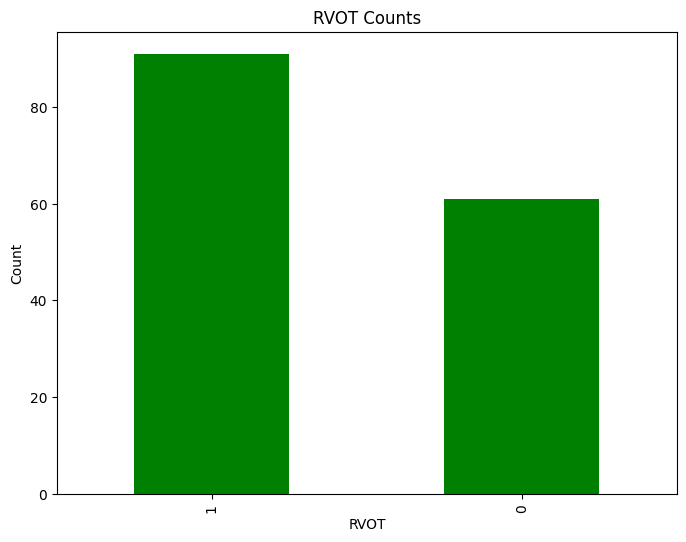

In [20]:
# Count the occurrences of each value in the RVOT column
rvot_counts = dfMl['RVOT'].value_counts()
print(rvot_counts)
# Create a bar graph
plt.figure(figsize=(8, 6))
rvot_counts.plot(kind='bar', color='green')
plt.title('RVOT Counts')
plt.xlabel('RVOT')
plt.ylabel('Count')

# Display the plot
plt.show()

LVOT
0    117
1     35
Name: count, dtype: int64


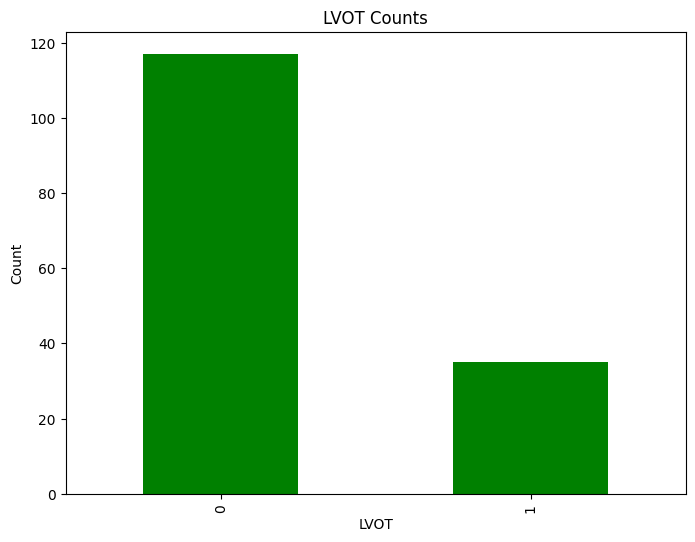

In [21]:
# Count the occurrences of each value in the LVOT column
lvot_counts = dfMl['LVOT'].value_counts()
print(lvot_counts)
# Create a bar graph
plt.figure(figsize=(8, 6))
lvot_counts.plot(kind='bar', color='green')
plt.title('LVOT Counts')
plt.xlabel('LVOT')
plt.ylabel('Count')

# Display the plot
plt.show()

RVOTSEPTUM
0    101
1     51
Name: count, dtype: int64


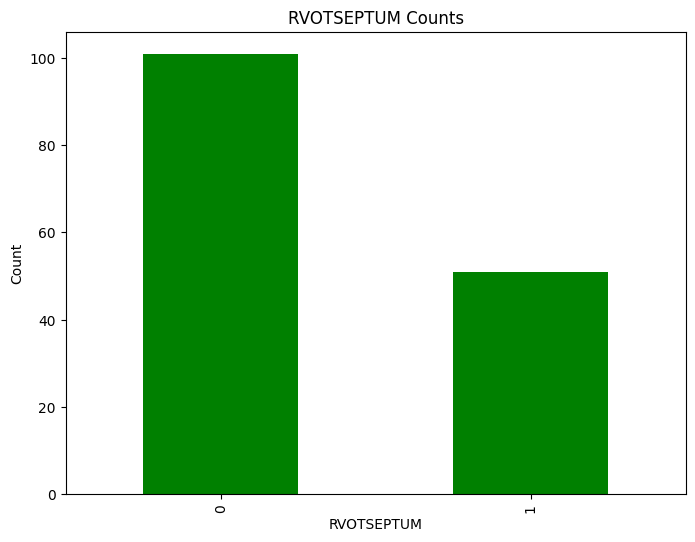

In [22]:
# Count the occurrences of each value in the RVOTSEPTUM column
rvotseptum_counts = dfMl['RVOTSEPTUM'].value_counts()
print(rvotseptum_counts)
# Create a bar graph
plt.figure(figsize=(8, 6))
rvotseptum_counts.plot(kind='bar', color='green')
plt.title('RVOTSEPTUM Counts')
plt.xlabel('RVOTSEPTUM')
plt.ylabel('Count')

# Display the plot
plt.show()

COMMISURE
0    140
1     12
Name: count, dtype: int64


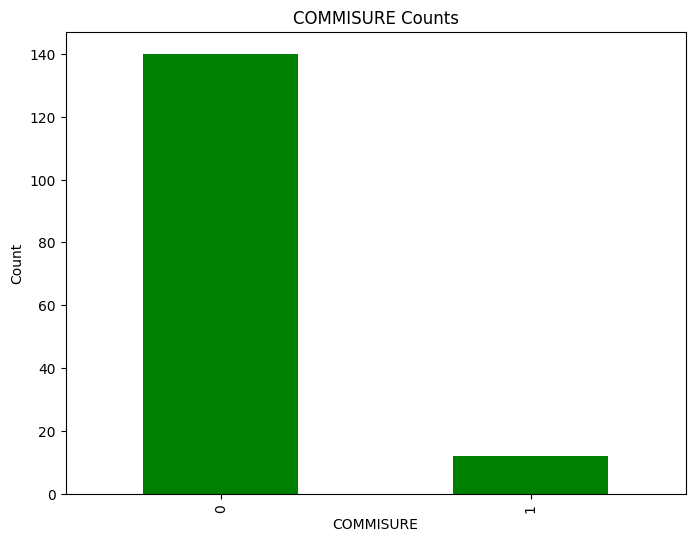

In [23]:
# Count the occurrences of each value in the COMMISURE column
commisure_counts = dfMl['COMMISURE'].value_counts()
print(commisure_counts)
# Create a bar graph
plt.figure(figsize=(8, 6))
commisure_counts.plot(kind='bar', color='green')
plt.title('COMMISURE Counts')
plt.xlabel('COMMISURE')
plt.ylabel('Count')

# Display the plot
plt.show()

## XGBoost

In [37]:
############################################################
columns_drop = ['LVOT', 'RVOT','RVOTSEPTUM','COMMISURE']
target = 'LVOT'
############################################################

Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.90      0.73      0.81        26
           1       0.30      0.60      0.40         5

    accuracy                           0.71        31
   macro avg       0.60      0.67      0.60        31
weighted avg       0.81      0.71      0.74        31

Confusion Matrix:
[[19  7]
 [ 2  3]]


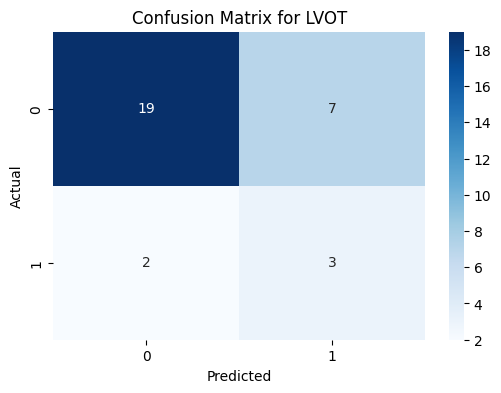

In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Define the feature columns and the target column
feature_columns = dfMl.columns.drop(columns_drop)
X = dfMl[feature_columns]
y = dfMl[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LVOT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forest

In [40]:
############################################################
columns_drop = ['LVOT', 'RVOT','RVOTSEPTUM','COMMISURE']
target = 'LVOT'
############################################################

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        26
           1       0.14      0.20      0.17         5

    accuracy                           0.68        31
   macro avg       0.49      0.48      0.48        31
weighted avg       0.72      0.68      0.70        31

Confusion Matrix:
[[20  6]
 [ 4  1]]


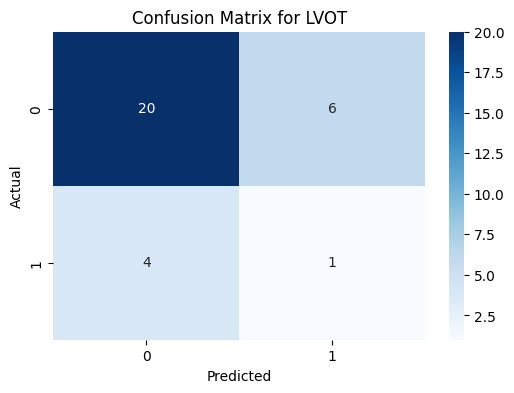

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Define the feature columns and the target column
feature_columns = dfMl.columns.drop(columns_drop)
X = dfMl[feature_columns]
y = dfMl[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LVOT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## KNN

In [42]:
############################################################
columns_drop = ['LVOT', 'RVOT','RVOTSEPTUM','COMMISURE']
target = 'LVOT'
############################################################

Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        26
           1       0.17      0.20      0.18         5

    accuracy                           0.71        31
   macro avg       0.50      0.50      0.50        31
weighted avg       0.73      0.71      0.72        31

Confusion Matrix:
[[21  5]
 [ 4  1]]


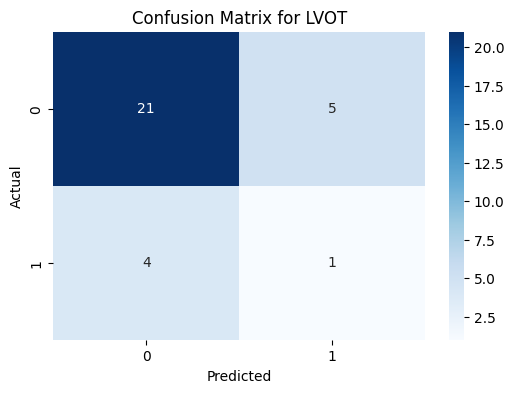

In [41]:
from sklearn.neighbors import KNeighborsClassifier

# Define the feature columns and the target column
feature_columns = dfMl.columns.drop(columns_drop)
X = dfMl[feature_columns]
y = dfMl[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model
model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LVOT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Logistic Regression

In [ ]:
############################################################
columns_drop = ['LVOT', 'RVOT','RVOTSEPTUM','COMMISURE']
target = 'LVOT'
############################################################

Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        26
           1       0.00      0.00      0.00         5

    accuracy                           0.77        31
   macro avg       0.41      0.46      0.44        31
weighted avg       0.69      0.77      0.73        31

Confusion Matrix:
[[24  2]
 [ 5  0]]


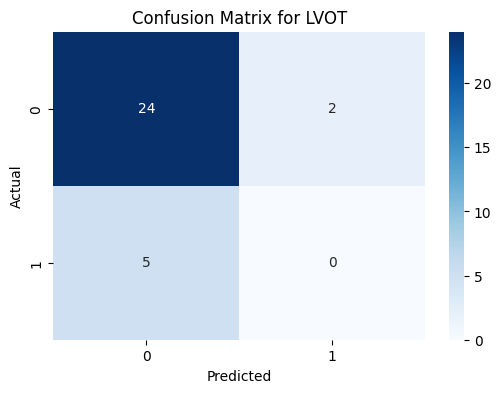

In [43]:
from sklearn.linear_model import LogisticRegression

# Define the feature columns and the target column
feature_columns = dfMl.columns.drop(columns_drop)
X = dfMl[feature_columns]
y = dfMl[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LVOT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## SVC

In [44]:
############################################################
columns_drop = ['LVOT', 'RVOT','RVOTSEPTUM','COMMISURE']
target = 'LVOT'
############################################################

Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        26
           1       0.00      0.00      0.00         5

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31

Confusion Matrix:
[[26  0]
 [ 5  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


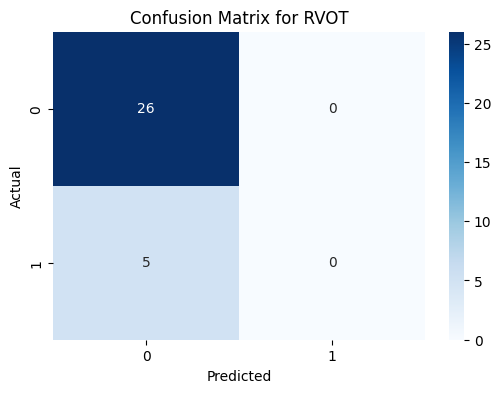

In [45]:
from sklearn.svm import SVC

# Define the feature columns and the target column
feature_columns = dfMl.columns.drop(columns_drop)
X = dfMl[feature_columns]
y = dfMl[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RVOT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()